## 06: Underwriting Agent

This notebook documents the `Underwriting Agent`: its theory, mathematical foundations, financial implications, safety properties, and a compact runnable reference implementation for prototyping and audit. 

### Executive summary

Underwriting maps deterministic features and external signals to a credit decision. We separate three concerns: (1) scoring (probability of default), (2) decision policy (thresholds, business rules), and (3) explanation/attribution for audit. The design must ensure reproducibility, bounded expected loss, and conservative automation when uncertainty or manipulation risk is high.

---
### Theory and math (concise)

We use a logistic surrogate for probability-of-default (PD). Let $\phi$ map event history $X_{\le t}$, persistent metadata $M$, and external signals $E$ to a deterministic feature vector $f_t \in \mathbb{R}^d$, and let $w \in \mathbb{R}^d$ be the fitted weights. Define the score and probability:

$$
S_t = w^{\top} f_t + b, \qquad PD_t = \sigma(S_t) = \frac{1}{1+e^{-S_t}}.
$$

From a finance perspective, expected loss (EL) for a loan exposure is:

$$
EL = PD \times EAD \times LGD,
$$

where $\mathrm{EAD}$ is exposure at default and $\mathrm{LGD}$ is loss given default. For portfolio-level risk, we aggregate EL across exposures and apply conservatism via model risk buffers derived from bootstrap or Bayesian uncertainty estimates.

Manipulation index $M_t$ flags features associated with persuasive or coercive language. Deterministic mitigation modifies scoring contributions from persuasion features to keep decisions within policy bounds.

---
### Procedural code: small end-to-end example

The code below demonstrates: (A) simulate toy features, (B) fit a logistic surrogate, (C) compute PD and EL, (D) compute a manipulation index and apply a simple mitigation. This is intentionally minimal and uses only `numpy` and `scikit-learn` for clarity.

fitted w = [-0.0586  0.7628  0.0201] b = -0.126
Score S=-1.514, PD=18.035%, EL=721.38
M=1.526 > 0.5, mitigated PD=4.567%


c:\Users\ADITI\Desktop\rhyl-projects\eclat\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


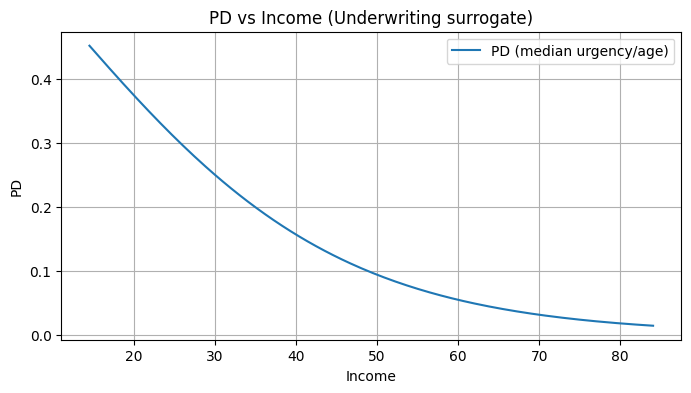

In [ ]:
# Requirements: numpy, (scikit-learn optional), matplotlib, seaborn, scipy
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.linear_model._logistic')
import numpy as np
import matplotlib.pyplot as plt

# Lightweight logistic fit fallback if scikit-learn is unavailable
try:
    from sklearn.linear_model import LogisticRegression
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

# 1) Simulate data
np.random.seed(0)
n = 1000
income = np.random.normal(50, 15, size=n)
urgency = np.random.poisson(0.5, size=n)
age = np.random.normal(40, 10, size=n)
X = np.vstack([income, urgency, age]).T
# generate binary default labels with a latent score
true_w = np.array([-0.05, 0.8, 0.01])  # note: urgency increases PD
logit = X.dot(true_w) - 0.2
prob = 1/(1+np.exp(-logit))
y = (np.random.rand(n) < prob).astype(int)

if SKLEARN_AVAILABLE:
    clf = LogisticRegression(solver='liblinear')
    clf.fit(X, y)
    w = clf.coef_[0]
    b = clf.intercept_[0]
else:
    # IRLS (Newton-Raphson / Iteratively Reweighted Least Squares) for logistic regression
    def fit_logistic_irls(X, y, reg=1e-6, maxiter=100, tol=1e-6):
        # X: (n, d)
        n, d = X.shape
        Xb = np.hstack([X, np.ones((n,1))])  # add intercept
        w = np.zeros(d+1)
        for i in range(maxiter):
            z = Xb.dot(w)
            p = 1/(1+np.exp(-z))
            W = p*(1-p)
            # build Hessian and gradient
            XWX = (Xb * W[:,None]).T.dot(Xb) + reg*np.eye(d+1)
            grad = Xb.T.dot(y - p) - reg*w
            try:
                delta = np.linalg.solve(XWX, grad)
            except np.linalg.LinAlgError:
                delta = np.linalg.lstsq(XWX, grad, rcond=None)[0]
            w += delta
            if np.linalg.norm(delta) < tol:
                break
        return w[:-1], w[-1]
    w, b = fit_logistic_irls(X, y)

print('fitted w =', np.round(w, 4), 'b =', np.round(b,4))

# 3) Compute PD and expected loss for a new example
example = np.array([60.0, 2.0, 30.0])
S = example.dot(w) + b
PD = 1/(1+np.exp(-S))
EAD = 10000.0
LGD = 0.4
EL = PD * EAD * LGD
print(f'Score S={S:.3f}, PD={PD:.3%}, EL={EL:.2f}')

# 4) Manipulation index and mitigation: reduce urgency contribution if M > threshold
beta = np.array([0.0, 1.0, 0.0])  # only urgency is persuasion-related

def manipulation_index(feature_vec, weights, beta):
    contrib = weights * feature_vec
    m = np.sum(beta * np.maximum(0, contrib))
    return m

M = manipulation_index(example, w, beta)
M_th = 0.5
if M > M_th:
    example_mitigated = example.copy()
    example_mitigated[1] = 0.0
    S2 = example_mitigated.dot(w) + b
    PD2 = 1/(1+np.exp(-S2))
    print(f'M={M:.3f} > {M_th}, mitigated PD={PD2:.3%}')
else:
    print(f'M={M:.3f} <= {M_th}, no mitigation')

# produce a simple PD vs income plot (matplotlib only)
try:
    import seaborn as sns
    sns.set()
except Exception:
    pass

income_grid = np.linspace(np.percentile(income,1), np.percentile(income,99), 200)
urg_med = np.median(urgency)
age_med = np.median(age)
PDs = []
for inc in income_grid:
    f = np.array([inc, urg_med, age_med])
    Sg = f.dot(w) + b
    PDs.append(1/(1+np.exp(-Sg)))

plt.figure(figsize=(8,4))
plt.plot(income_grid, PDs, label='PD (median urgency/age)')
plt.xlabel('Income')
plt.ylabel('PD')
plt.title('PD vs Income (Underwriting surrogate)')
plt.grid(True)
plt.legend()
plt.show()


---
### Council context & grounding constraint

This system is built as a council of five witnesses (Master + 4 Workers). We follow Clark & Brennan's Grounding Theory: every message presented to a customer must be acknowledged, repaired, or clarified within three conversational turns. Operationally the `Underwriting Agent` contributes symbolic reasoning, SHAP attributions, and human-readable explanations to the council; it is never the sole authority.

Architectural notes (links & pieces):

- Architectural diagram (system-level): https://www.figma.com/board/rcJdgpXsnJoKwy2CD9uPBS/Master-Agent-Orchestration-Flowchart?node-id=0-1&t=i0A3NYN2kYJJmlT2-1
- Underwriting diagram: https://www.figma.com/board/kNlXfClcgDTKUI3o0W002n/Underwriting-Decision-Flowchart?node-id=0-1&t=vqWal1M2pOByMyl2-1

Technology and design highlights specific to Underwriting:

- Prefect 3.0 for robust flows and treating failure as a first-class artifact. Use `@flow` decorations to materialize failures into artifacts that can be inspected by Sales for conversational repair.
- Symbolic rule engine for primary rules; SymPy for precise financial algebra and sensitivity analysis.
- Surrogate scoring (linear/logistic) with SHAP attribution maps for explainability. Store `w`, `f_t`, and SHAP vectors in artifacts for exact replay.

Financial invariants and usage:

- Expected Loss: $EL = PD\times EAD\times LGD$. Use conservative add-ons for estimation error and model risk.
- Provide a SHAP-based explanation for any decline which the Master Agent can translate into plain language for the customer.

Grounding enforcement (deterministic snippet):

```python
# enforce 3-turn grounding: every outgoing message must be ack/clarified/repaired within 3 turns
class GroundingTracker:
    def __init__(self):
        # store counts per trace
        self.turns = {}
    def note_outgoing(self, trace_id):
        self.turns[trace_id] = 0
    def note_incoming(self, trace_id, acknowledged=False, repaired=False):
        if trace_id not in self.turns:
            return False
        if acknowledged or repaired:
            del self.turns[trace_id]
            return True
        self.turns[trace_id] += 1
        if self.turns[trace_id] >= 3:
            # escalate to human or conservative policy
            return False
        return True
```

Notes: log `turns` as an artifact so auditors can verify grounding behavior for each trace.

---
### Expanded deep dive: Underwriting (theory, finance, visualization)

This expanded section unpacks the underwriting agent in depth: rationale, statistical foundations, model risk adjustments, regulatory considerations, and visual analytics for auditors and product managers.

Key concepts (long-form):

- Risk as a distribution: Instead of treating creditworthiness as a point estimate, model the borrower's horizon as a distribution over future states. The logistic surrogate provides a parametric estimate of PD; use Bayesian or ensemble techniques to quantify epistemic uncertainty and produce conservative decision bands.

- Financial math and prudential add-ons: For regulatory prudence, compute portfolio-level Expected Loss (EL) and add model risk buffers. Let $PD_t$ be the point estimate and $\widehat{PD}_t^{(u)}$ a conservative upper bound (e.g., 95th percentile from an ensemble). Use $EL^{(u)} = \widehat{PD}_t^{(u)} \times EAD \times LGD$ for provisioning guidance.

- Attribution & fairness: Use exact surrogate contributions $w_i f_i$ for explanations; compute SHAP-like local attributions by linearizing around the decision point for consistency with audits. Apply a fairness validator that inspects contributions from features correlated with protected attributes and penalizes urgency-like features when credit proxies are low.

- Operational policy mapping: Translate numeric outputs to policy actions (approve, refer, decline, manual review). Each mapping is codified in `policy_version` artifacts and must be deterministic and replayable.

Visualization goals:

- PD slice plots (PD vs income/age), contribution bar charts, and uncertainty bands. These make audits and reviewers comfortable that the model is behaving as intended.

#### Plot: PD vs income and feature contributions

```python
# Requirements: numpy, matplotlib, seaborn, sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# simulate data (same as earlier cell but larger for visualization)
np.random.seed(42)
n = 3000
income = np.random.normal(50, 20, size=n)
urgency = np.random.poisson(0.7, size=n)
age = np.random.normal(40, 12, size=n)
X = np.vstack([income, urgency, age]).T
true_w = np.array([-0.04, 0.9, 0.01])
logit = X.dot(true_w) - 0.3
prob = 1/(1+np.exp(-logit))
y = (np.random.rand(n) < prob).astype(int)

clf = LogisticRegression(penalty='l2', solver='liblinear')
clf.fit(X, y)
w = clf.coef_[0]; b = clf.intercept_[0]

# PD curve vs income (fix other features at medians)
income_grid = np.linspace(np.percentile(income,1), np.percentile(income,99), 200)
urg_med = np.median(urgency)
age_med = np.median(age)
PDs = []
for inc in income_grid:
    f = np.array([inc, urg_med, age_med])
    S = f.dot(w) + b
    PDs.append(1/(1+np.exp(-S)))

plt.figure(figsize=(8,5))
plt.plot(income_grid, PDs, label='PD (median urgency/age)')
plt.xlabel('Income (k)')
plt.ylabel('PD')
plt.title('PD vs Income (Underwriting surrogate)')
plt.grid(True)
plt.legend()
plt.show()

# Contribution bar (w_i * f_i) for a sample borrower
sample = np.array([60.0, 2.0, 30.0])
contrib = w * sample
features = ['income','urgency','age']
plt.figure(figsize=(6,4))
sns.barplot(x=features, y=contrib)
plt.title('Feature contributions (w_i * f_i) for sample borrower')
plt.ylabel('Contribution to score')
plt.show()
```


---
### Bayesian PD, model risk, and prudential buffers

This section gives a compact, formal derivation for quantifying model uncertainty and deriving prudential provisioning add-ons used in conservative underwriting.

**Bayesian view of PD (Beta-Binomial conjugacy):**

- Treat observed defaults in a population segment as Binomial(n, p) and place a Beta(a,b) prior on p. The posterior is Beta(a+K, b+N-K) where K is observed defaults and N is exposures. The posterior mean is \(\frac{a+K}{a+b+N}\) and a conservative upper bound (e.g., 95th percentile) can be computed from the Beta quantile function. Use this upper bound as \(\widehat{PD}^{(u)}\) for provisioning.

**Bootstrap/ensemble uncertainty for parametric surrogates:**

- For a fitted surrogate (logistic), approximate epistemic uncertainty by bootstrap resampling the training data, refitting, and computing the ensemble of PD estimates. Use the empirical 95th percentile across the ensemble as a conservative PD.

**Portfolio provisioning:**

- For each exposure i compute \(EL_i^{(u)} = \widehat{PD}_i^{(u)} \times EAD_i \times LGD_i\). Aggregate across portfolio and add model risk buffer \(B_{model}\) (e.g., percent of total EL) calibrated by stress tests.

References: Bayesian estimation, bootstrap theory, regulator-prescribed buffers.


AUC = 0.7669


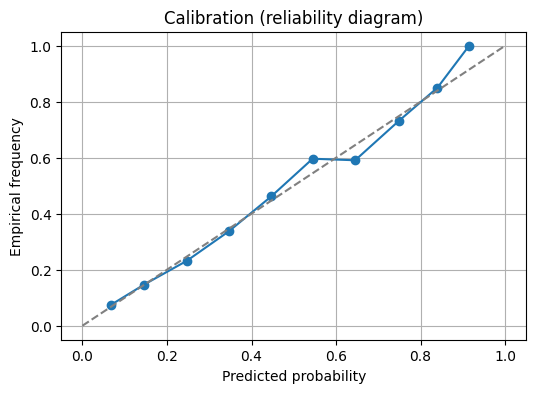

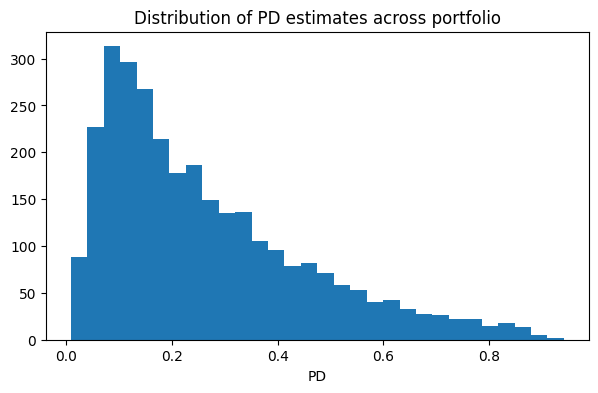

sample PD point estimate: 0.1260628654226009
sample PD 95th percentile: 0.1431679345739673


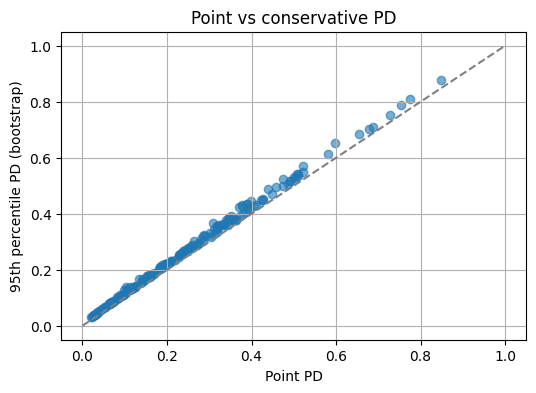

segment posterior mean PD: 0.26449033977348435
segment posterior 95th PD: 0.27781808102496297
Portfolio EL (point) = 3172857.44, (conservative) = 3448373.48


In [7]:
# Modeling + uncertainty + visualization
# Requirements: numpy, matplotlib, sklearn, scipy
import os
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.linear_model._logistic')
import numpy as np
# Prefer inline backend when running inside a Jupyter kernel; fall back to Agg for headless runs
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except Exception:
    import matplotlib
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
from scipy.stats import beta

os.makedirs('artifacts', exist_ok=True)

np.random.seed(0)
# simulate dataset
n = 3000
income = np.random.normal(50, 20, size=n)
urgency = np.random.poisson(0.7, size=n)
age = np.random.normal(40, 12, size=n)
X = np.vstack([income, urgency, age]).T
true_w = np.array([-0.04, 0.9, 0.01])
logit = X.dot(true_w) - 0.3
prob = 1/(1+np.exp(-logit))
y = (np.random.rand(n) < prob).astype(int)

# fit logistic surrogate
clf = LogisticRegression(solver='liblinear')
clf.fit(X, y)
w = clf.coef_[0]; b = clf.intercept_[0]

# compute ROC and AUC
probs = clf.predict_proba(X)[:,1]
auc = roc_auc_score(y, probs)
print(f'AUC = {auc:.4f}')

# calibration (reliability diagram)
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y, probs, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('Predicted probability')
plt.ylabel('Empirical frequency')
plt.title('Calibration (reliability diagram)')
plt.grid(True)
plt.savefig('artifacts/calibration.png')
plt.show()
plt.close()

# PD distribution across portfolio
plt.figure(figsize=(7,4))
plt.hist(probs, bins=30)
plt.title('Distribution of PD estimates across portfolio')
plt.xlabel('PD')
plt.savefig('artifacts/pd_distribution.png')
plt.show() 
plt.close()

# bootstrap ensemble for epistemic uncertainty (simple)
B = 50
ensemble_probs = np.zeros((B, len(X)))
for i in range(B):
    idx = np.random.choice(len(X), size=len(X), replace=True)
    clf_b = LogisticRegression(solver='liblinear')
    clf_b.fit(X[idx], y[idx])
    ensemble_probs[i] = clf_b.predict_proba(X)[:,1]

# compute 95th percentile PD for each example as conservative bound
pd_95 = np.percentile(ensemble_probs, 95, axis=0)

# example: compare point PD vs conservative PD for a sample
sample_idx = 10
print('sample PD point estimate:', probs[sample_idx])
print('sample PD 95th percentile:', pd_95[sample_idx])

# plot sample of PD point vs pd_95
plt.figure(figsize=(6,4))
plt.scatter(probs[:200], pd_95[:200], alpha=0.6)
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('Point PD')
plt.ylabel('95th percentile PD (bootstrap)')
plt.title('Point vs conservative PD')
plt.grid(True)
plt.savefig('artifacts/point_vs_conservative_pd.png')
plt.show()
plt.close()

# Bayesian Beta posterior example for segment-level provisioning
# suppose in a segment we observed K defaults out of N exposures
K = y.sum()
N = len(y)
# weak prior (a=b=1) -> uniform
a0, b0 = 1.0, 1.0
post_a = a0 + K
post_b = b0 + N - K
# posterior mean and 95th percentile
post_mean = post_a / (post_a + post_b)
post_95 = beta.ppf(0.95, post_a, post_b)
print('segment posterior mean PD:', post_mean)
print('segment posterior 95th PD:', post_95)

# portfolio EL aggregation under conservative PD
EAD = 10000.0
LGD = 0.4
EL_point = np.sum(probs * EAD * LGD)
EL_cons = np.sum(pd_95 * EAD * LGD)
print(f'Portfolio EL (point) = {EL_point:.2f}, (conservative) = {EL_cons:.2f}')
